In [39]:
%matplotlib inline
from ipywidgets import widgets
from math import sqrt
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import os,glob, dicom, cv2, random, csv
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
from skimage import measure, morphology, segmentation, filters
from skimage.segmentation import clear_border, slic, mark_boundaries
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing, watershed
from skimage.util import img_as_float
from skimage.filters import roberts, sobel
from skimage.feature import blob_dog, blob_log, blob_doh
import scipy.ndimage as ndi

In [40]:
def getSolution(patient):
    csvpath = "../KaggleData/stage1/stage1_solution.csv"
    with open(csvpath) as f:
        reader = csv.reader(f)
        n=0
        for row in reader:
            n += 1
            if n == patient:
                return row[0], row[1]

In [41]:
def get_slice_location(dcm):
    return float(dcm[0x0020, 0x1041].value)

# Returns a list of images for that patient_id, in ascending order of Slice Location
def load_patient(patient_id):
#     files = glob.glob('./KaggleData/sample_images/{}/*.dcm'.format(patient_id))
    files = patient_images
    imgs = {}
    for f in files:
        dcm = dicom.read_file(f)
        img = dcm.pixel_array
        img[img == -2000] = 0
        sl = get_slice_location(dcm)
        imgs[sl] = img
        
    # Not a very elegant way to do this
    sorted_imgs = [x[1] for x in sorted(imgs.items(), key=lambda x: x[0])]
    return sorted_imgs

In [42]:
def tr_mask(img):
    a = np.array([[263,312],[242,292],[212,241],[236,176],[276,220],[288,256],[263,312]])
    im1 = np.ones((img.shape[0], img.shape[1]))
    im1 = cv2.fillPoly(im1, [a], 0)
    hv = im1 == 0
    img[hv] = 0
    return img

In [43]:
def dcm2rgb(image):
    image2 = image.copy()
    image2[image2 == -2000] = 0
    for i in range(image2.shape[0]):
        for j in range(image2.shape[1]):
            image2[i][j] = np.interp(image2[i][j], [0,2250], [0,225])
    image2 = np.uint8(image2)
    image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)
    return image2

In [44]:
def segment_lungs(im, plot=False):
    binary = im < 604
    cleared = clear_border(binary)
    label_image = label(cleared)
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    selem = disk(1)
    binary = binary_erosion(binary, selem)
    selem = disk(10)
    binary = binary_closing(binary, selem)
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    get_high_vals = binary == 0
    im[get_high_vals] = 0        
    return im

In [45]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([segment_lungs(slice) for slice in ct_scan])

In [46]:
def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices

In [47]:
def blob_segments_simple(image, scan_image):
    image = np.array(image, np.uint8)
    dummy_image = np.zeros((image.shape[0], image.shape[1]))
    params = cv2.SimpleBlobDetector_Params()
    # Change thresholds
    params.minThreshold = 1;
    params.maxThreshold = 605;
    
    # Filter by Area.
    params.filterByColor = True
    params.blobColor = 255
    #params.maxArea =500
    
    # Filter by Area.
    params.filterByArea = True
    params.minArea = 30
    params.maxArea =150

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.1

#     Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.001

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.2
    
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(image)
    n_keypoints = len(keypoints)
    
    for kpt in keypoints:
        scan_image = cv2.circle(scan_image, (int(kpt.pt[0]), int(kpt.pt[1])), int(kpt.size//2), color = (255,0,0), thickness =2 )
        dummy_image = cv2.circle(dummy_image, (int(kpt.pt[0]), int(kpt.pt[1])), int(kpt.size//2), color = (255,0,0), thickness = -1)

    points = dummy_image == 0
    image[points] = 0
    return scan_image, dummy_image

In [53]:
def dynamic_viz_temp(id):
    global idx
    plt.close('all')
#     id = int(input_text.value)
    id = id + len(ct_scan)//4
    image = ct_scan[id]
    print(image.shape)
    image2 = image.copy()
    image2 = tr_mask(image2)
    image_seg = segment_lungs(image2)
    image_seg[image_seg <  604] = 0
    
    image_seg2 = image_seg.copy()
    
    image_nob, label_image = blob_segments_simple(image_seg2, dcm2rgb(image.copy()))
    
    fig, ax = plt.subplots(2,2, figsize = [15,15])
    fig.suptitle("Segmentation process for patient {0}".format(patient), fontsize = 18)
    ax[0,0].imshow(image, cmap='gray')
    ax[0,0].set_title("CT scan image of patient {0}".format(patient))
    ax[0,0].axis('off')
    
    ax[0,1].imshow(image_seg, cmap=plt.cm.bone)
    ax[0,1].set_title("Segmented lung image")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(label_image, cmap=plt.cm.bone)
    ax[1,0].set_title("Segmented label image of each nodules")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(image_nob, cmap=plt.cm.bone)
    ax[1,1].set_title("Annotated image with nodules")
    ax[1,1].axis('off')
    
    plt.savefig("{0}_{1}.png".format(patient, id))
    plt.show()

In [49]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

In [50]:
image_folder = "../KaggleData/stage1/data/stage1/"
patients = os.listdir(image_folder)
randN = random.randint(0, 199)
patient, cancer_label = getSolution(randN)
patient, cancer_label = "026470d51482c93efc18b9803159c960", 1
 
ct_scan = read_ct_scan(image_folder+patient+"/")
save_fig = False
idx = len(ct_scan)//4

In [51]:
def on_button_clicked(b):
    global save_fig
    save_fig = True
    plt.savefig("{0}_{1}.png".format(patient, id))
    print("Saving figure")

(512, 512)


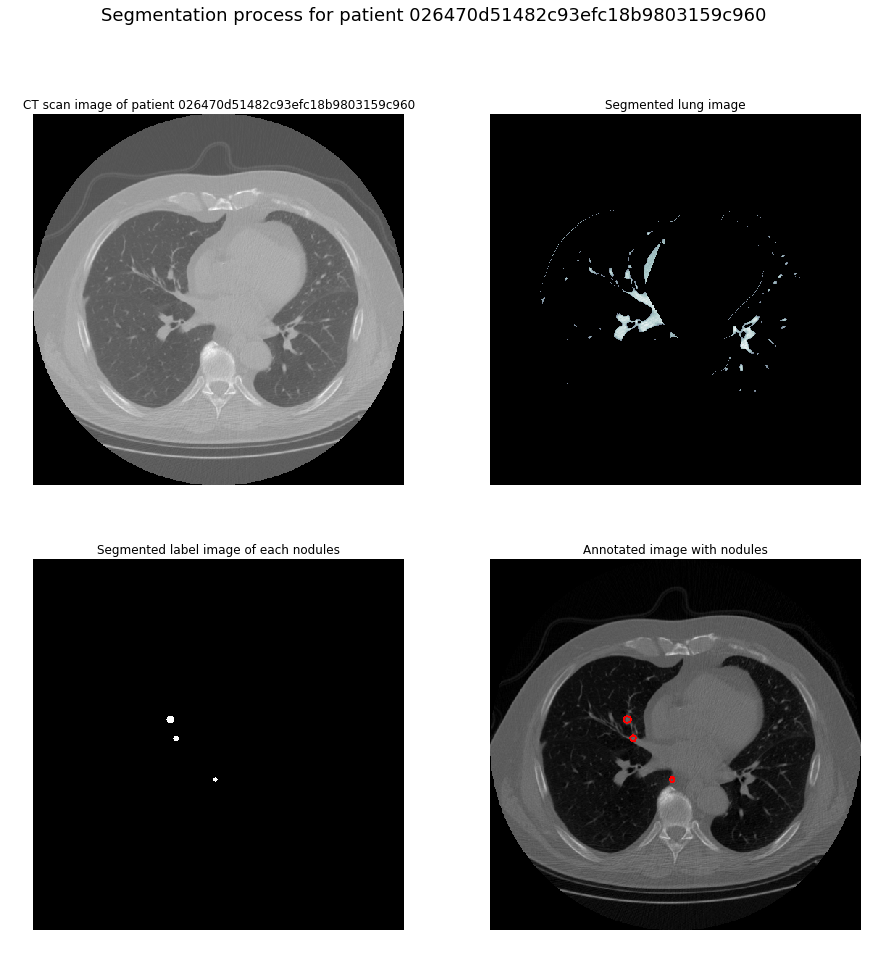

In [54]:
interact(dynamic_viz_temp, id=len(ct_scan)//4)
button = widgets.Button(description = "Save figure")
display(button)
button.on_click(on_button_clicked)